# Ranzr Kaggle
> A tutorial of fastpages for Jupyter notebooks.

- toc: true
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]
- hide: true

This post will accomplish 2 things:

1. Demonstrate top 10 LB scoring submission in a multi-label image classification problem
2. Compare doing this in fastai vs pure pytorch

>Note:  I do not use fastai all the time myself.  For example I found it a lot easier when working with StyleGAN (2 generators/2 discriminators)  This is a "See why fastai should be an additional tool in your toolbelt" post, not a "This is why fastai should be used exclusively post"

Now, I do realize that there are some things I prefer doing in pure pytorch.  For example, I was working with StyleGan (2 generators/2 discriminators all in the same training loop) and I was having a hard time building it out and getting it working in fastai.  So I used pure pytorch.  I don't always use fastai myself.  This isn't to be used as irrefutable proof that you should always use fastai.


Being a person who likes to simplify things as much as possible I thought "Maybe I should really be doing everything in pure pytorch...".  So I set out to do a new image classification problem using pure pytorch.  I ended up switching back to fastai.  That leads me to the first goal of the article: To show the differences between solving an image classicifation problem in pytorch vs fastai!

The second goal is to do this well.  It always bothers me a bit that comparisons are done using toy problems or really easy problems.  The truth is that every library looks simple, easy, and gets good results effortlessly on these.  I could compare using MNIST or some other easy dataset, but a library being able to solve MNIST in a clean way isn't that valuable.  

In [1]:
!pip install -Uqq fastai

In [2]:
import torch.nn as nn
import torch
import pandas as pd
import timm
from fastai.vision.all import *
from fastcore.foundation import *
from fastcore.xtras import *
from pathlib import Path
from torch import Tensor
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io
import random
import matplotlib.pyplot as plt
import math
import albumentations as A

In [3]:
path = Path('./tmp')
path.ls()

(#6) [Path('tmp/train.csv'),Path('tmp/sample_submission.csv'),Path('tmp/train_annotations.csv'),Path('tmp/train'),Path('tmp/test'),Path('tmp/image_shapes.csv')]

https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/overview

# Data Cleaning

In [4]:
# ds = RanzrDataset(train,(path/'train'))

# shapes = L()
# for i in range(len(ds)):
#     shapes.append(ds[i]['x'].shape)
    
# shape_df = pd.DataFrame(np.array(shapes))
# shape_df[2] = 1
# shape_df.groupby([0,1]).count().sort_values(2,ascending=False).to_csv(path/'image_shapes.csv')

# Dataset

+ maybe something based on same patient tested multiple times

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get ith sample

In [5]:
train = pd.read_csv(path/'train.csv')
# annot = pd.read_csv(path/'train_annotations.csv')
# samp_sub = pd.read_csv(path/'sample_submission.csv')
train['is_valid'] = np.random.rand(len(train))>0.8
train['StudyInstanceUID'] = './tmp/train/'+train['StudyInstanceUID']+'.jpg'
train['multi-label'] = None
for r in range(len(train)): train.iloc[r,-1]  = '|'.join([train.columns[i+1] for i in range(10) if train.iloc[r,i+1] == 1])
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,is_valid,multi-label
0,./tmp/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg,0,0,0,0,0,0,1,0,0,0,0,ec89415d1,True,NGT - Normal
1,./tmp/train/1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729.jpg,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c,False,ETT - Normal|NGT - Incompletely Imaged|CVC - Normal
2,./tmp/train/1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577.jpg,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,False,CVC - Borderline
3,./tmp/train/1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744.jpg,0,0,0,0,0,0,0,1,0,0,0,c31019814,False,CVC - Abnormal
4,./tmp/train/1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175.jpg,0,0,0,0,0,0,0,0,0,1,0,207685cd1,False,CVC - Normal


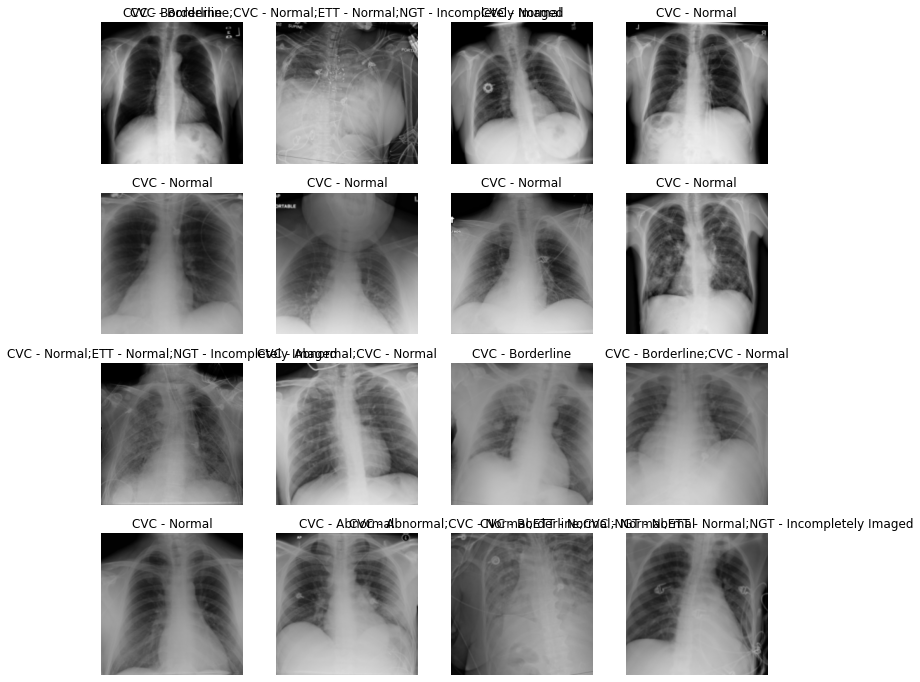

In [11]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader('StudyInstanceUID'),
                   get_y=ColReader('multi-label', label_delim='|'),
                   splitter=ColSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224,p_lighting=0.9,flip_vert=False,max_zoom=1.2,max_warp=0))

dls = dblock.dataloaders(train)
dls.show_batch(max_n=16)

In [13]:
learn = cnn_learner(dls,resnet18,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time


AssertionError: ==:
64
640

In [9]:
abc

NameError: name 'abc' is not defined

In [6]:
class RanzrDataset(Dataset):
    def __init__(self, df, path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path,self.df.iloc[idx, 0]) + '.jpg'
        
        image = io.imread(img_name)
        if self.transform: image = self.transform(image)     
            
        y = Tensor(self.df.iloc[idx, 1:-2])
        
        batch = {'x': image, 'y': y}
        
        return batch
    
    def show_batch(self,rows=2, cols=5):
        idxs = random.sample(range(self.__len__()), cols*rows)        
        fig, ax = plt.subplots(rows, cols,figsize=(4*cols,5*rows))
        
        for row in range(0,rows):
            for col in range(0,cols):
                num = (row * cols + col)
                x = self[idxs[num]]['x']
                
                lbls = pd.DataFrame([train.columns[1:-3],self[idxs[num]]['y'].numpy().astype(int)]).transpose()                
                y = self[idxs[num]]['y']
                ax[row,col].imshow(x)
                ax[row,col].set_title("\n".join(list(lbls.loc[lbls[1]==1][0].values)))
                ax[row,col].get_xaxis().set_visible(False)
                ax[row,col].get_yaxis().set_visible(False)

train_dl = DataLoader(RanzrDataset(train[train.is_valid == False],(path/'train')), batch_size=16, shuffle=True, num_workers=8)
valid_dl = DataLoader(RanzrDataset(train[train.is_valid == True],(path/'train')), batch_size=16, shuffle=True, num_workers=8)

FileNotFoundError: No such file: '/home/github/fastblog/_notebooks/tmp/train/tmp/train/1.2.826.0.1.3680043.8.498.11428406517036900264027317719140491691.jpg.jpg'

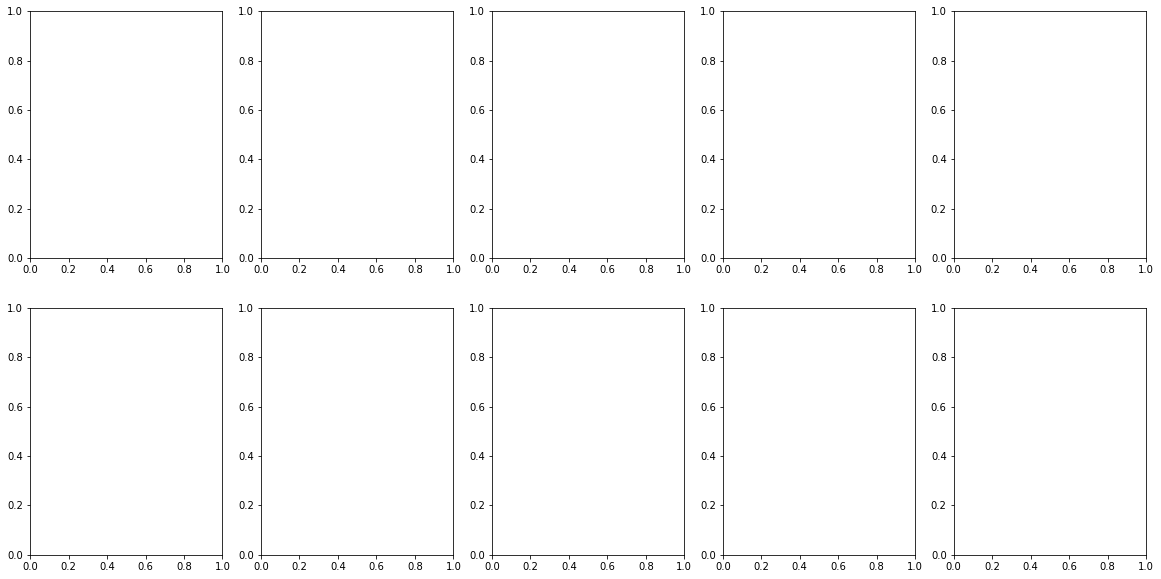

In [7]:
train_dl.dataset.show_batch()

# Transforms

# Loss Function

In [ ]:
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

# Optimizer

In [ ]:
from torch.optim import lr_scheduler
class WarmRestart(lr_scheduler.CosineAnnealingLR):
    def __init__(self, optimizer, T_max=10, T_mult=2, eta_min=0, last_epoch=-1):
        self.T_mult = T_mult
        super().__init__(optimizer, T_max, eta_min, last_epoch)

    def get_lr(self):
        if self.last_epoch == self.T_max:
            self.last_epoch = 0
            self.T_max *= self.T_mult
        return [
            self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
            for base_lr in self.base_lrs
        ]

def warm_restart(scheduler, T_mult=2):
    if scheduler.last_epoch == scheduler.T_max:
        scheduler.last_epoch = -1
        scheduler.T_max *= T_mult
    return scheduler

# Model

In [ ]:
#vit_base_resnet26d_224, seresnext50_32x4d

model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=10)
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
x     = torch.randn(1, 3, 224, 224)
model(x).shape

# Training

In [1]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

NameError: name 'trainloader' is not defined

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')